In [1]:
import os
# running from Root directory
os.chdir("..")

In [2]:
from motif_search_main import load_network_from_args
from utils.export_import import import_results
from utils.logs import log_motif_criteria_args, log_motif_results, log_sub_graph_args, log_randomizer_args, log_motifs_table
from utils.types import MotifCriteriaArgs, MotifType, MotifName, Motif
import matplotlib.pyplot as plt
import networkx as nx
from typing import Union
import numpy as np
from collections import defaultdict
import collections
from networkx.algorithms import isomorphism
from subgraphs.sub_graphs_utils import get_sub_graph_mapping_to_motif


In [3]:
data = import_results('results/pol_k3_m5.bin')
# data = import_results('results/cmpx_pol_k3_m5.bin')
# data = import_results('results/cmpx_pol_k3_m10.bin')
# data = import_results('results/cook_si2_chem_k4_m5.bin')

args = data['args']
motifs = data['motifs']

if args.input_network_file.startswith('../'):
    args.input_network_file = "/".join(args.input_network_file.strip("/").split('/')[1:])

network = load_network_from_args(args)

log_motif_criteria_args(MotifCriteriaArgs(**vars(args)))
log_sub_graph_args(args)
log_randomizer_args(args)
log_motif_results(motifs)
for motif in motifs.values():
    log_motifs_table([m for m in motif.polarity_motifs if m.motif_criteria.is_motif != MotifType.none])


Network file name: s1_data.xlsx
Sheet name: 5. Sign prediction
Filtering Neurons with polarity: ['+', '-']
Filtering Neurons with primary neurotransmitter: ['Glu', 'GABA', 'ACh', 0]
Polarity ratios (before filtering): Counter({'+': 0.757420091324201, '-': 0.2425799086757991})

Network properties:
	Neurons: 283
	Neurons with a Synapse: 283
	Synapses in the network: 11650

	Participating Nodes are neurons in a tuple with at least: 5 synapses
	Synapses in the graph: 9515
	Nodes: 259
	Edges: 661
	Average clustering coefficient: 0.06
	Average shortest path (undirected): 2.038
	Density: 0.01
	Polarity ratios: Counter({'+': 0.7881996974281392, '-': 0.2118003025718608})
	Degree: Mean: 5.104 Std: 4.445 Median: 4.0 Max: 25 (node: RIAL)
	In-Degree: Mean: 2.552 Std: 3.973 Median: 1.0 Max: 23 (node: AVBL)
	Out-Degree: Mean: 2.552 Std: 2.283 Median: 2.0 Max: 13 (node: RIML)

Motif criteria:
	alpha: 0.01
	use uniqueness: False
	uniqueness threshold: 3
	frequency threshold: 0.1

Sub Graph search using

In [4]:
def plot_motif_distribution(motifs_, anti_motifs_, none_motifs_):
    sizes = [len(motifs_), len(anti_motifs_), len(none_motifs_)]
    labels = [MotifType.motif.value, MotifType.anti_motif.value, MotifType.none.value]

    fig, ax = plt.subplots()
    ax.pie(sizes, labels=labels, autopct='%1.1f%%')
    total = sum(sizes)
    for s,l in zip(sizes, labels):
        print(f'{l}: {s}/{total}')

In [5]:
def draw_motif(motif: Motif, ax):
    ax.axis('off')
    
    title = f'{motif.name.value}-{motif.id}' if motif.name.value != MotifName.na else motif.id
    ax.set_title(title, fontsize=7.5)

    graph = nx.DiGraph(motif.role_pattern)
    pos = nx.circular_layout(graph)
    nx.draw_networkx(graph, pos, ax=ax)
    
    if motif.polarity:
        for role, pol in zip(motif.role_pattern, motif.polarity):
            s,t = role
            graph[s][t]['polarity'] = 'c' if pol == 'complex' else pol

        edge_labels=dict([((u,v,),d['polarity']) for u,v,d in graph.edges(data=True)])
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, ax=ax, font_color='k', font_weight='bold', label_pos=0.3)

In [6]:
def plot_motifs_z(motifs_list: list[Motif], motif_type: MotifType, top=10):
    if not len(motifs_list):
        return
        
    reverse_sort = True if motif_type == MotifType.motif else False
    sorted_by_z = sorted(motifs_list, key=lambda m: m.motif_criteria.z_score, reverse=reverse_sort)
    sorted_by_z = sorted_by_z[:top]

    z_scores = [abs(round(m.motif_criteria.z_score, 2)) for m in sorted_by_z]
    ids_ = [str(m.id) for m in sorted_by_z]
    n_reals = [m.n_real for m in sorted_by_z]
    n_rands = [m.motif_criteria.n_rand for m in sorted_by_z]

    figure = plt.figure()
    figure.set_size_inches(top, 4)
    
    plt.title(f'Z-score of {motif_type.value}s')
    plt.ylabel('Z-score')
    plt.xlabel('Motif id')

    plt.bar(ids_, z_scores)

    for x, y, n_real, n_rand in zip(ids_, z_scores, n_reals, n_rands):
       plt.text(x, y, f'n_real: {n_real}\nn_rand: {n_rand}', ha='center', fontsize=7.5)
    plt.show()
    
    # plot the graphs
    num_of_graphs = len(sorted_by_z)
    fig, ax = plt.subplots(nrows=1, ncols=num_of_graphs, figsize=(num_of_graphs*2, 2))
    fig.set_size_inches(num_of_graphs*2, 2)

    for idx, motif in enumerate(sorted_by_z):  
        ax_ = ax if num_of_graphs == 1 else ax[idx]
        draw_motif(motif, ax_)

In [7]:
def plot_motif_roles(motif: Motif, top=5):
    roles = motif.node_roles.keys()
    num_of_rows = len(roles)
    if num_of_rows == 0:
        print(f'n_real: {motif.n_real}')
        return
    fig, ax = plt.subplots(nrows=num_of_rows, ncols=1, figsize=(top, 4*num_of_rows))
    title = f'{motif.name.value}-{motif.id}' if motif.name.value != MotifName.na else motif.id
    fig.suptitle(f'Motif - {title}: node roles')
    fig.text(0.5, 0.01, 'Node name', ha='center', va='center')
    fig.text(0.1, 0.5, 'Freqency', ha='center', va='center', rotation='vertical')

    for idx, role in enumerate(roles):
        nodes = list(motif.node_roles[role])[:top]
        freqs = list(motif.node_roles[role].values())[:top]
        ax_ = ax[idx]
        ax_.bar(nodes, freqs)
        ax_.set_title(f'role: {role}')

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2, 2))
    draw_motif(motif, ax) 

def get_polarity_index(motif: Motif, polarity: list[str]):
    pol_ids = [m.polarity for m in motif.polarity_motifs]
    return pol_ids.index(polarity)

In [8]:
def node_properties(node: Union[str, int], top=15):
    print(f'Node {node} properties:')
    
    node_idx = network.neuron_names.index(node) if isinstance(node, str) else node
    print(f'Degree: {network.graph.degree[node_idx]}')
    print(f'Out Degree: {network.graph.out_degree[node_idx]}')
    print(f'In Degree: {network.graph.in_degree[node_idx]}')
    print(f'Clustering coefficient: {round(nx.average_clustering(network.graph, nodes=[node_idx]), 3)}')

    node_freq_in_motifs = {str(motif.id): motif.node_appearances.get(node, 0) for motif in motifs.values()}
    # filter only nodes that appear at least 1
    node_freq_in_motifs = {x:y for x,y in node_freq_in_motifs.items() if y!=0}
    
    freq_sorted = dict(sorted(node_freq_in_motifs.items(), key=lambda ele: ele[1], reverse=True))
    # plt.figure()

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(top, 4))
    ax.set_title(f'Appearance of node: {node} in sub-graphs')
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Sub-graph id')

    ax.bar(list(freq_sorted.keys())[:top], list(freq_sorted.values())[:top])
    # plt.show()

In [9]:
def get_polarity_sub_graph_mapping_to_motif(sub_graph: tuple[tuple], pol_motif: Motif) -> dict:
    motif_graph = nx.DiGraph()
    motif_graph.add_edges_from(pol_motif.role_pattern)
    
    graph = nx.DiGraph()
    graph.add_edges_from(sub_graph)
    
    for role, pol in zip(pol_motif.role_pattern, pol_motif.polarity):
        s,t = role
        motif_graph[s][t]['polarity'] = 'complex' if pol == 'complex' else pol

    matcher = isomorphism.GraphMatcher(motif_graph, graph, edge_match=lambda e1,e2: e1['polarity'] == e2['polarity'])
    if not (matcher.is_isomorphic()):
        raise Exception('The sub graph is not isomorphic to the motif')
    return dict(matcher.mapping)

def get_motif_sub_graphs_of_node(motif: Motif, node: Union[str, int], role: str, print_neuron_names=True):
    motif_name = f'{motif.name.value}-{motif.id}' if motif.name.value != MotifName.na else motif.id
    print(f'Node "{node}" as role "{role}" - sub graphs in Motif {motif_name}:')

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2, 2))
    draw_motif(motif, ax) 
    
    node_idx = network.neuron_names.index(node) if isinstance(node, str) else node
    
    for sub_graph in motif.sub_graphs:
        if motif.polarity:
            role_nodes_mapping = get_polarity_sub_graph_mapping_to_motif(sub_graph, motif)
        else:
            role_nodes_mapping = get_sub_graph_mapping_to_motif(sub_graph, motif.role_pattern)

        if role_nodes_mapping[role] != node_idx:
            continue
            
        if network.neuron_names:
            role_nodes_mapping_w_neuron_names = {k:network.neuron_names[role_nodes_mapping[k]] for k in role_nodes_mapping}

        roles_to_print = role_nodes_mapping_w_neuron_names if print_neuron_names else role_nodes_mapping
        print(roles_to_print)


In [10]:
def draw_sub_graph(neurons: list[str], center=None):
    node_list = [network.neuron_names.index(neuron) for neuron in neurons]
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.axis('off')
    
    induced_sub_graph = nx.induced_subgraph(network.graph, node_list)
    mapping = {i: n for i, n in enumerate(network.neuron_names)}
    graph = nx.relabel_nodes(induced_sub_graph, mapping)
    
    pos = nx.circular_layout(graph)
    if center:
        pos[center] = np.array([0, 0])
    nx.draw_networkx(graph, pos=pos, ax=ax, node_size=600, node_color='lightgreen')
    
    edge_labels = nx.get_edge_attributes(graph, 'polarity')
    for label in edge_labels:
        if edge_labels[label] == 'complex':
            edge_labels[label] = 'c'
    nx.draw_networkx_edge_labels(graph, pos=pos, ax=ax, edge_labels=edge_labels, font_color='k', font_weight='bold', label_pos=0.2)

def draw_neighbors(neuron: str):
    neighbors = [network.neuron_names[i] for i in list(network.graph.neighbors(network.neuron_names.index(neuron)))]
    neighbors.append(neuron)
    draw_sub_graph(neighbors, center=neuron)

In [11]:
polarity_dict = {'+': 0, '-': 1, 'complex': 2}

def _get_polarity_motif_graph(motif: Motif):
    graph = nx.DiGraph(motif.role_pattern)
    for role, pol in zip(motif.role_pattern, motif.polarity):
        s,t = role
        graph[s][t]['polarity'] = polarity_dict[pol]
    return graph

def _is_polarity_sim_isomorphic(g1, g2):
    """
    check if two graphs of a SIM polarity motif are isomorphic.
    returns True if number of symbols, e.g.: #"+" == #"-". otherise False.
    """
    g1_pol_counter = collections.Counter(nx.get_edge_attributes(g1, 'polarity').values())
    g2_pol_counter = collections.Counter(nx.get_edge_attributes(g2, 'polarity').values())
    return g1_pol_counter == g2_pol_counter

def remove_isomorphic_polarity_motifs(motif: Motif):
    isomorphic = defaultdict(dict)    
    for pol_motif in motif.polarity_motifs:
        sub_graph = _get_polarity_motif_graph(pol_motif)
        sub_id = pol_motif.id
        
        found = False
        for reps_graph_id in isomorphic:
            reps_graph = isomorphic[reps_graph_id]['reps_graph']
            # TODO: motif sub_algo_type == 'sim'... instead of isinstance
            if isinstance(motif.id, str):
                if _is_polarity_sim_isomorphic(reps_graph, sub_graph):
                    found = True
                    break
            else:
                if nx.is_isomorphic(reps_graph, sub_graph, edge_match=lambda e1,e2: e1['polarity'] == e2['polarity']):
                    found = True
                    break
                
        if found:
            isomorphic[reps_graph_id]['list'].append(sub_id)
            
        if not found:
            isomorphic[sub_id]['reps_graph'] = sub_graph
            isomorphic[sub_id]['list'] = [sub_id]

    remove_sum = 0
    for iso in isomorphic:
        remove_list = isomorphic[iso]['list'][1:]
        remove_sum += len(remove_list)
        for sub_id in remove_list:
            pol_motif = [m for m in motif.polarity_motifs if m.id == sub_id][0]  
            motif.polarity_motifs.remove(pol_motif)
            
    print(f'removed {remove_sum} isomorphic graphs from motif: {motif.id}')

motif: 7/18
anti-motif: 5/18
none: 6/18


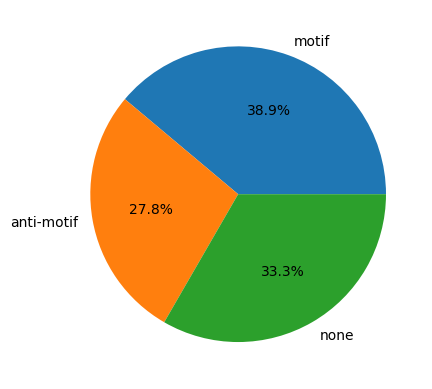

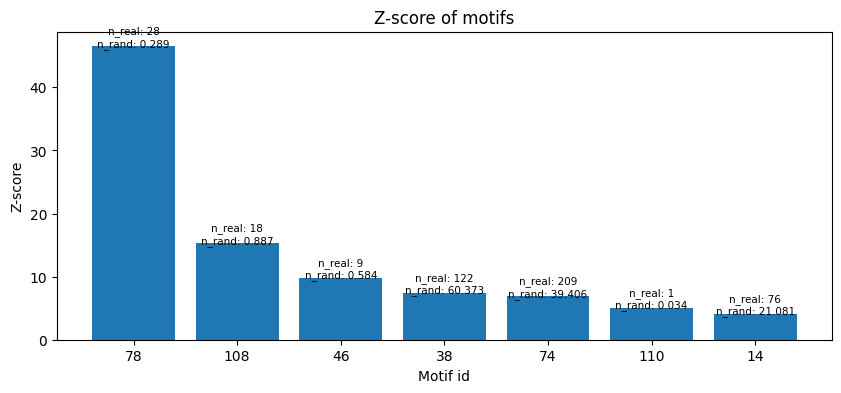

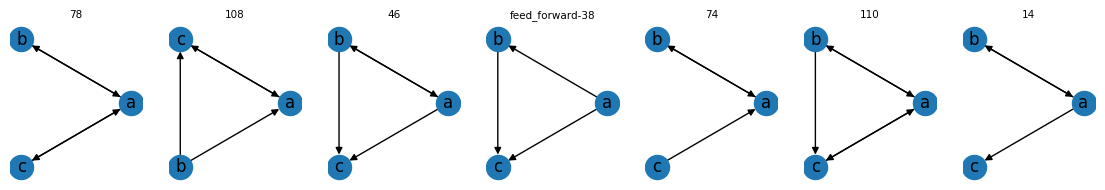

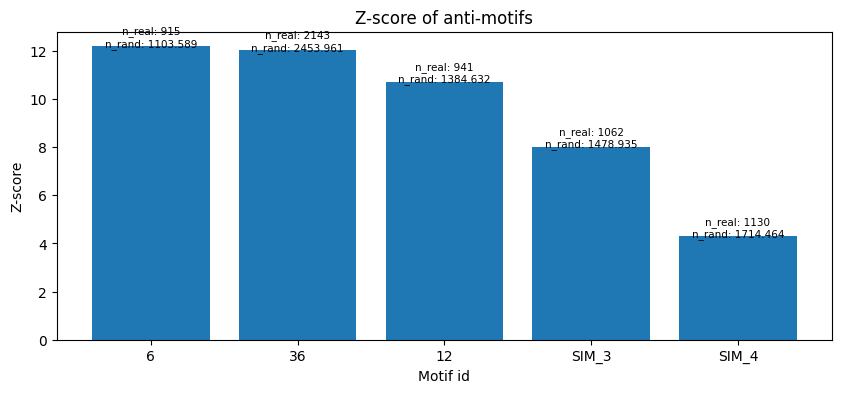

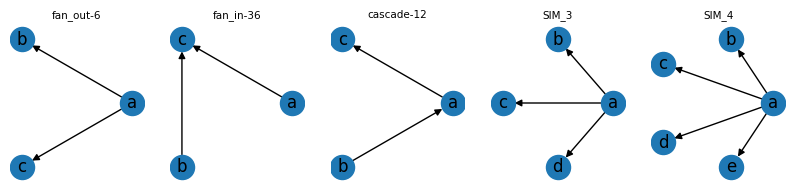

In [12]:
motifs_ = [m for m in motifs.values() if m.motif_criteria.is_motif == MotifType.motif]
anti_motifs_ = [m for m in motifs.values() if m.motif_criteria.is_motif == MotifType.anti_motif]
none_motifs_ = [m for m in motifs.values() if m.motif_criteria.is_motif == MotifType.none]

plot_motif_distribution(motifs_, anti_motifs_, none_motifs_)
plot_motifs_z(motifs_, MotifType.motif, top=10)
plot_motifs_z(anti_motifs_, MotifType.anti_motif, top=10)

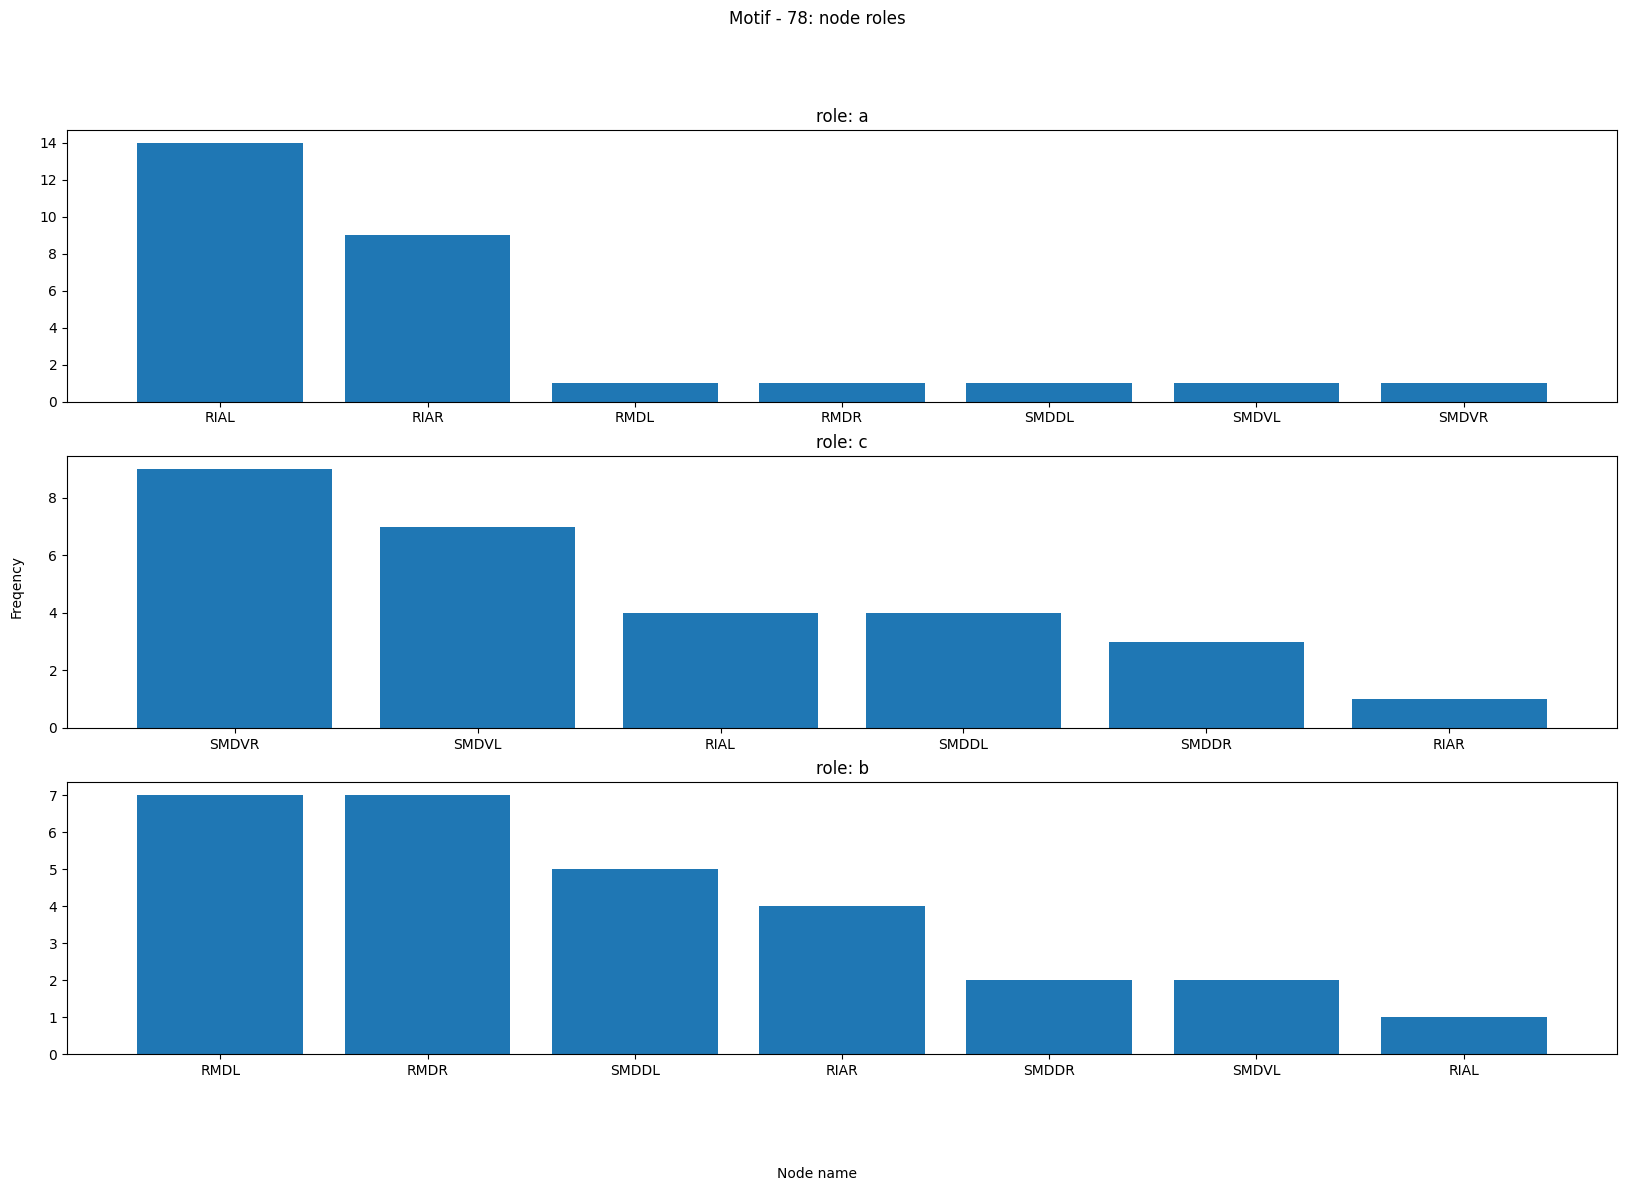

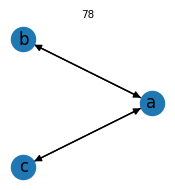

In [13]:
plot_motif_roles(motifs[78], top=20)

Node "RIAL" as role "a" - sub graphs in Motif 78:
{'b': 'RMDL', 'a': 'RIAL', 'c': 'SMDDL'}
{'b': 'RMDL', 'a': 'RIAL', 'c': 'SMDDR'}
{'b': 'RMDL', 'a': 'RIAL', 'c': 'SMDVL'}
{'b': 'RMDL', 'a': 'RIAL', 'c': 'SMDVR'}
{'b': 'RMDR', 'a': 'RIAL', 'c': 'SMDDL'}
{'b': 'RMDR', 'a': 'RIAL', 'c': 'SMDDR'}
{'b': 'RMDR', 'a': 'RIAL', 'c': 'SMDVL'}
{'b': 'RMDR', 'a': 'RIAL', 'c': 'SMDVR'}
{'b': 'SMDDL', 'a': 'RIAL', 'c': 'SMDDR'}
{'b': 'SMDDL', 'a': 'RIAL', 'c': 'SMDVL'}
{'b': 'SMDDL', 'a': 'RIAL', 'c': 'SMDVR'}
{'b': 'SMDDR', 'a': 'RIAL', 'c': 'SMDVL'}
{'b': 'SMDDR', 'a': 'RIAL', 'c': 'SMDVR'}
{'b': 'SMDVL', 'a': 'RIAL', 'c': 'SMDVR'}


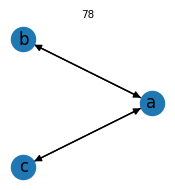

In [14]:
get_motif_sub_graphs_of_node(motifs[78], node='RIAL', role='a')

Node RIAL properties:
Degree: 25
Out Degree: 10
In Degree: 15
Clustering coefficient: 0.043


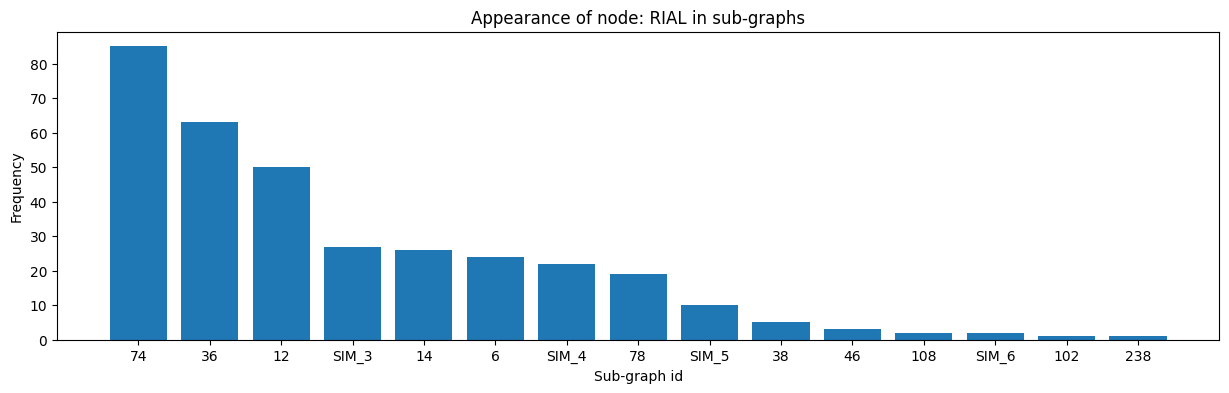

In [15]:
node_properties('RIAL', top=15)

Polarity

removed 1 isomorphic graphs from motif: 6
removed 0 isomorphic graphs from motif: 12
removed 0 isomorphic graphs from motif: 14
removed 1 isomorphic graphs from motif: 36
removed 0 isomorphic graphs from motif: 38
removed 6 isomorphic graphs from motif: 46
removed 0 isomorphic graphs from motif: 74
removed 6 isomorphic graphs from motif: 78
removed 4 isomorphic graphs from motif: 98
removed 0 isomorphic graphs from motif: 102
removed 6 isomorphic graphs from motif: 108
removed 0 isomorphic graphs from motif: 110
removed 48 isomorphic graphs from motif: 238
removed 4 isomorphic graphs from motif: SIM_3
removed 11 isomorphic graphs from motif: SIM_4
removed 26 isomorphic graphs from motif: SIM_5
removed 57 isomorphic graphs from motif: SIM_6
removed 120 isomorphic graphs from motif: SIM_7
motif: 22/162
anti-motif: 8/162
none: 132/162


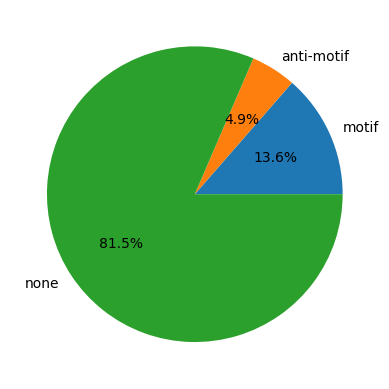

In [16]:
import copy
motifs_copy = copy.deepcopy(motifs)

al_polarities = []
for m in motifs_copy.values():
    # this may unfortunately remove motifs
    remove_isomorphic_polarity_motifs(motif=m)
    al_polarities.extend(m.polarity_motifs)

motifs_ = [m for m in al_polarities if m.motif_criteria.is_motif == MotifType.motif]
anti_motifs_ = [m for m in al_polarities if m.motif_criteria.is_motif == MotifType.anti_motif]
none_motifs_ = [m for m in al_polarities if m.motif_criteria.is_motif == MotifType.none]
plot_motif_distribution(motifs_, anti_motifs_, none_motifs_)

motif: 29/452
anti-motif: 10/452
none: 413/452


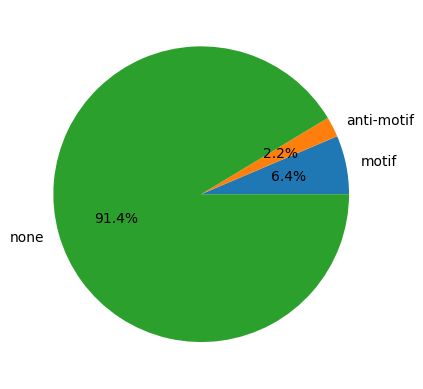

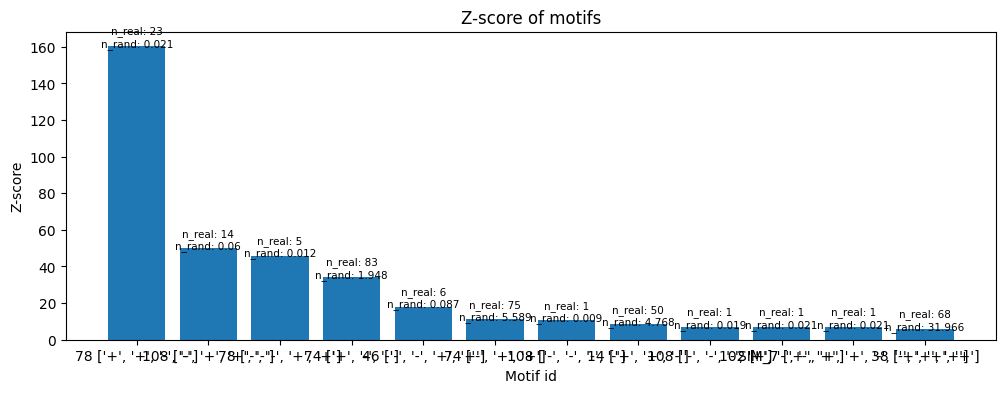

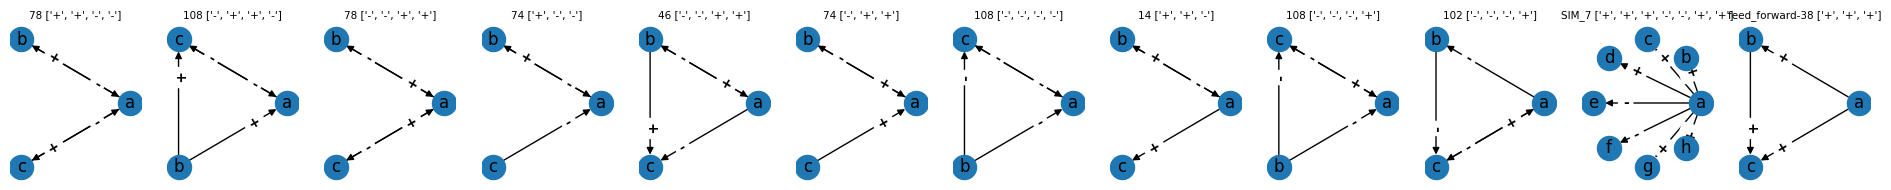

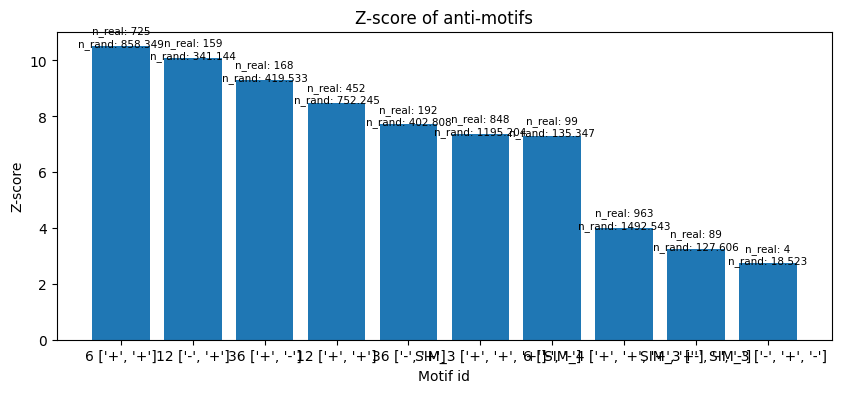

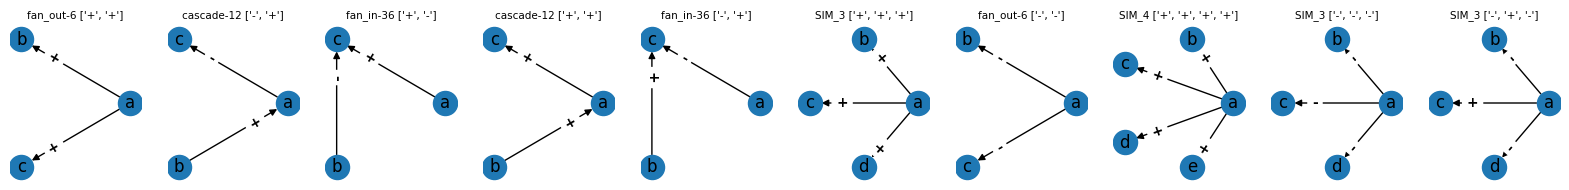

In [36]:
# 2nd time
al_polarities = []
for m in motifs.values():
    al_polarities.extend(m.polarity_motifs)

motifs_ = [m for m in al_polarities if m.motif_criteria.is_motif == MotifType.motif]
anti_motifs_ = [m for m in al_polarities if m.motif_criteria.is_motif == MotifType.anti_motif]
none_motifs_ = [m for m in al_polarities if m.motif_criteria.is_motif == MotifType.none]

plot_motif_distribution(motifs_, anti_motifs_, none_motifs_)
plot_motifs_z(motifs_, MotifType.motif, top=12)
plot_motifs_z(anti_motifs_, MotifType.anti_motif)

In [32]:
# example for cmpx_pol_k3_m5

# [m.id for m in motifs_]
# pol_motif_ = motifs_[-1]
# pol_motif_

In [33]:
# plot_motif_roles(pol_motif_)

In [34]:
# get_motif_sub_graphs_of_node(pol_motif_, node='PVCR', role='a')

In [35]:
# draw_neighbors('PVCR')

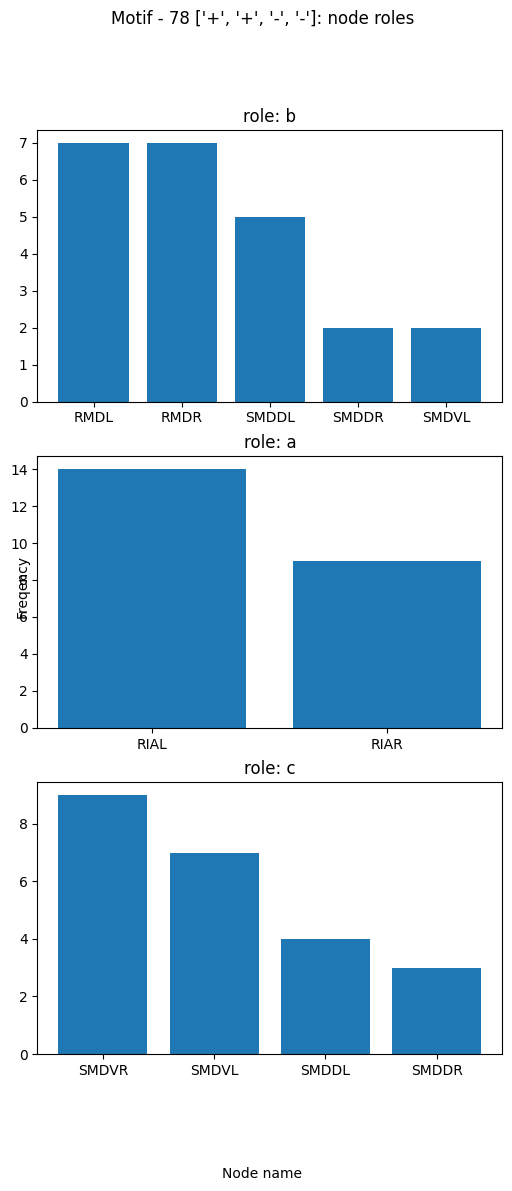

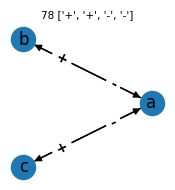

In [22]:
motif_ = motifs[78]
# cmpx m10
# polarity = ['complex', '-', 'complex', '+']

#cmpx m5
polarity = ['+', '+', '-', '-']


# polarity = ['-', '-', '+','+']
pol_idx = get_polarity_index(motif_, polarity)
plot_motif_roles(motif_.polarity_motifs[pol_idx], top=6)

Node "RIAL" as role "a" - sub graphs in Motif 78 ['+', '+', '-', '-']:
{'b': 'RMDL', 'a': 'RIAL', 'c': 'SMDDL'}
{'b': 'RMDL', 'a': 'RIAL', 'c': 'SMDDR'}
{'b': 'RMDL', 'a': 'RIAL', 'c': 'SMDVL'}
{'b': 'RMDL', 'a': 'RIAL', 'c': 'SMDVR'}
{'b': 'RMDR', 'a': 'RIAL', 'c': 'SMDDL'}
{'b': 'RMDR', 'a': 'RIAL', 'c': 'SMDDR'}
{'b': 'RMDR', 'a': 'RIAL', 'c': 'SMDVL'}
{'b': 'RMDR', 'a': 'RIAL', 'c': 'SMDVR'}
{'b': 'SMDDL', 'a': 'RIAL', 'c': 'SMDDR'}
{'b': 'SMDDL', 'a': 'RIAL', 'c': 'SMDVL'}
{'b': 'SMDDL', 'a': 'RIAL', 'c': 'SMDVR'}
{'b': 'SMDDR', 'a': 'RIAL', 'c': 'SMDVL'}
{'b': 'SMDDR', 'a': 'RIAL', 'c': 'SMDVR'}
{'b': 'SMDVL', 'a': 'RIAL', 'c': 'SMDVR'}


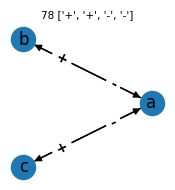

In [23]:
get_motif_sub_graphs_of_node(motif_.polarity_motifs[pol_idx], node='RIAL', role='a')

In [24]:
sim_motif = motifs['SIM_3']

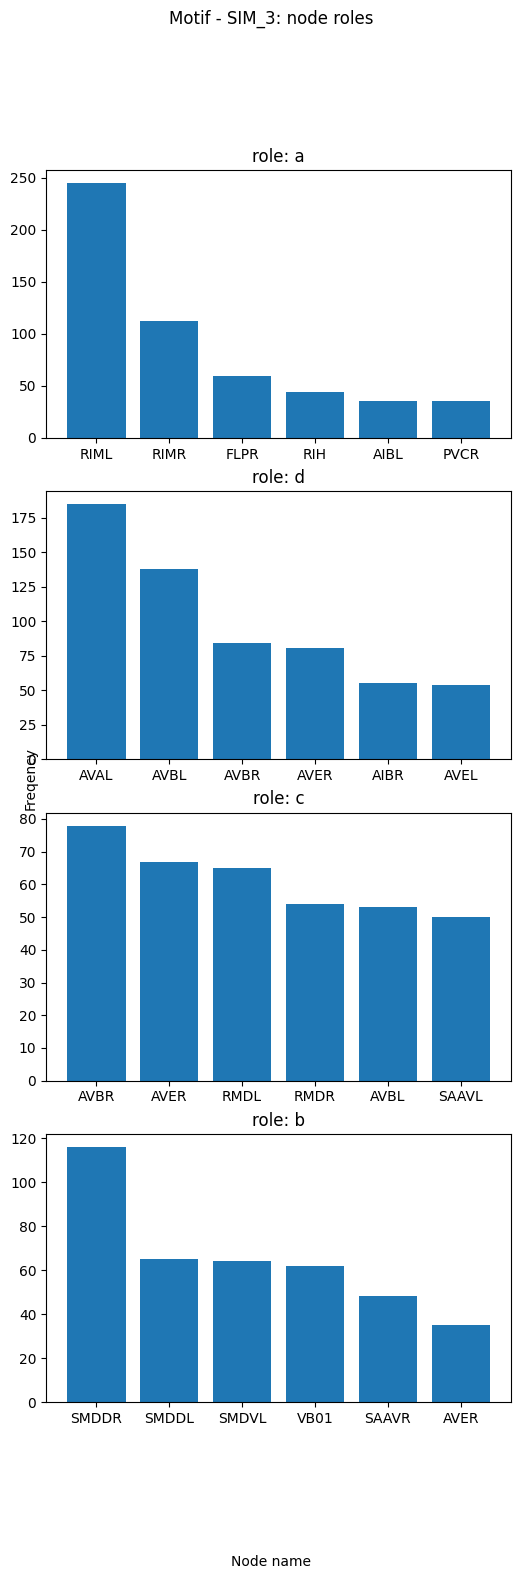

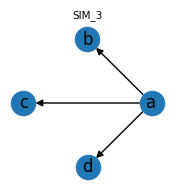

In [25]:
plot_motif_roles(sim_motif, top=6)

Node "RIMR" as role "a" - sub graphs in Motif SIM_3:
{'a': 'RIMR', 'c': 'AIBL', 'b': 'AVBR', 'd': 'RMDL'}
{'a': 'RIMR', 'c': 'AIBL', 'b': 'AVBR', 'd': 'RMDR'}
{'a': 'RIMR', 'c': 'AIBL', 'b': 'AVBR', 'd': 'SAAVL'}
{'a': 'RIMR', 'c': 'AIBL', 'b': 'AVBR', 'd': 'SAAVR'}
{'a': 'RIMR', 'c': 'AIBL', 'b': 'AVBR', 'd': 'SMDDL'}
{'a': 'RIMR', 'c': 'AIBL', 'b': 'RMDL', 'd': 'SAAVL'}
{'a': 'RIMR', 'c': 'AIBL', 'b': 'RMDL', 'd': 'SAAVR'}
{'a': 'RIMR', 'c': 'AIBL', 'b': 'RMDL', 'd': 'SMDDL'}
{'a': 'RIMR', 'c': 'AIBL', 'b': 'RMDR', 'd': 'SAAVL'}
{'a': 'RIMR', 'c': 'AIBL', 'b': 'RMDR', 'd': 'SAAVR'}
{'a': 'RIMR', 'c': 'AIBL', 'b': 'RMDR', 'd': 'SMDDL'}
{'a': 'RIMR', 'c': 'AIBL', 'b': 'SAAVL', 'd': 'SAAVR'}
{'a': 'RIMR', 'c': 'AIBL', 'b': 'SAAVL', 'd': 'SMDDL'}
{'a': 'RIMR', 'c': 'AIBL', 'b': 'SAAVR', 'd': 'SMDDL'}
{'a': 'RIMR', 'c': 'AVAL', 'b': 'AVBL', 'd': 'AVBR'}
{'a': 'RIMR', 'c': 'AVAL', 'b': 'AVBL', 'd': 'RMDL'}
{'a': 'RIMR', 'c': 'AVAL', 'b': 'AVBL', 'd': 'RMDR'}
{'a': 'RIMR', 'c': 'AVAL', 'b':

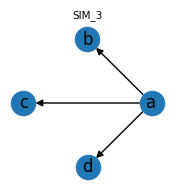

In [26]:
get_motif_sub_graphs_of_node(sim_motif, node='RIMR', role='a')

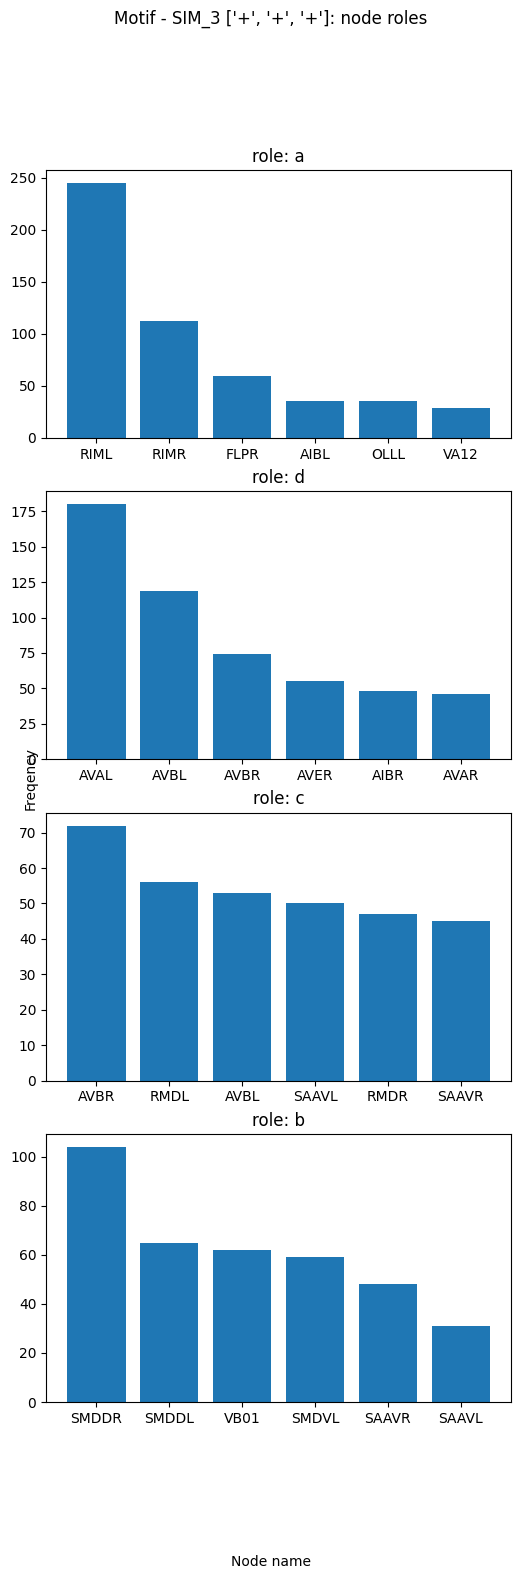

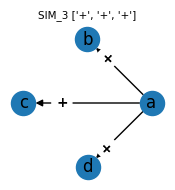

In [27]:
plot_motif_roles(sim_motif.polarity_motifs[0], top=6)

Node "RIMR" as role "a" - sub graphs in Motif SIM_3 ['+', '+', '+']:
{'a': 'RIMR', 'c': 'AIBL', 'b': 'AVBR', 'd': 'RMDL'}
{'a': 'RIMR', 'c': 'AIBL', 'b': 'AVBR', 'd': 'RMDR'}
{'a': 'RIMR', 'c': 'AIBL', 'b': 'AVBR', 'd': 'SAAVL'}
{'a': 'RIMR', 'c': 'AIBL', 'b': 'AVBR', 'd': 'SAAVR'}
{'a': 'RIMR', 'c': 'AIBL', 'b': 'AVBR', 'd': 'SMDDL'}
{'a': 'RIMR', 'c': 'AIBL', 'b': 'RMDL', 'd': 'SAAVL'}
{'a': 'RIMR', 'c': 'AIBL', 'b': 'RMDL', 'd': 'SAAVR'}
{'a': 'RIMR', 'c': 'AIBL', 'b': 'RMDL', 'd': 'SMDDL'}
{'a': 'RIMR', 'c': 'AIBL', 'b': 'RMDR', 'd': 'SAAVL'}
{'a': 'RIMR', 'c': 'AIBL', 'b': 'RMDR', 'd': 'SAAVR'}
{'a': 'RIMR', 'c': 'AIBL', 'b': 'RMDR', 'd': 'SMDDL'}
{'a': 'RIMR', 'c': 'AIBL', 'b': 'SAAVL', 'd': 'SAAVR'}
{'a': 'RIMR', 'c': 'AIBL', 'b': 'SAAVL', 'd': 'SMDDL'}
{'a': 'RIMR', 'c': 'AIBL', 'b': 'SAAVR', 'd': 'SMDDL'}
{'a': 'RIMR', 'c': 'AVAL', 'b': 'AVBL', 'd': 'AVBR'}
{'a': 'RIMR', 'c': 'AVAL', 'b': 'AVBL', 'd': 'RMDL'}
{'a': 'RIMR', 'c': 'AVAL', 'b': 'AVBL', 'd': 'RMDR'}
{'a': 'RIMR', '

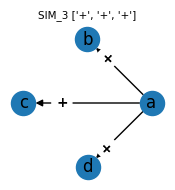

In [28]:
get_motif_sub_graphs_of_node(sim_motif.polarity_motifs[0], node='RIMR', role='a')

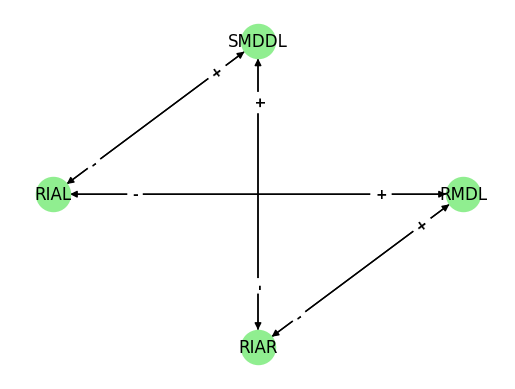

In [29]:
draw_sub_graph(['RMDL', 'RIAL', 'RIAR', 'SMDDL'])

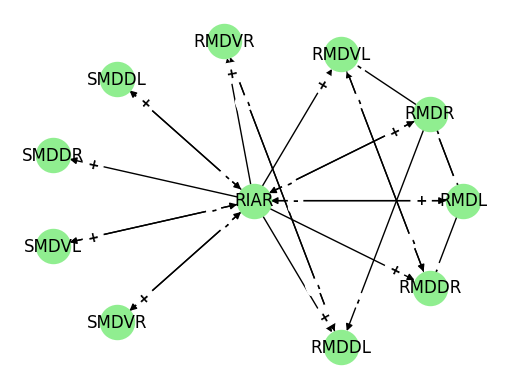

In [30]:
draw_neighbors('RIAR')

TMP

In [31]:
from tqdm.notebook import trange, tqdm
import time
import random

motif = motifs['SIM_3']
polarity_dict = {'+': 0, '-': 1, 'complex': 2}

def _get_polarity_motif_graph(motif: Motif):
    graph = nx.DiGraph(motif.role_pattern)
    for role, pol in zip(motif.role_pattern, motif.polarity):
        s,t = role
        graph[s][t]['polarity'] = polarity_dict[pol]
    return graph


isomorphic = defaultdict(dict)
for pol_motif in tqdm(motif.polarity_motifs):
    sub_graph = _get_polarity_motif_graph(pol_motif)
    sub_id = pol_motif.id
    
    found = False
    for reps_graph_id in isomorphic:
        reps_graph = isomorphic[reps_graph_id]['reps_graph']
        if _is_polarity_sim_isomorphic(reps_graph, sub_graph):
            isomorphic[reps_graph_id]['list'].append(sub_id)
            found = True
            break

    if not found:
        isomorphic[sub_id]['reps_graph'] = sub_graph
        isomorphic[sub_id]['list'] = [sub_id]
        
for sub_id in isomorphic:
    for l in isomorphic[sub_id]['list']:
        print(l)
    print()


  0%|          | 0/8 [00:00<?, ?it/s]

SIM_3 ['+', '+', '+']

SIM_3 ['+', '+', '-']
SIM_3 ['+', '-', '+']
SIM_3 ['-', '+', '+']

SIM_3 ['+', '-', '-']
SIM_3 ['-', '+', '-']
SIM_3 ['-', '-', '+']

SIM_3 ['-', '-', '-']

